In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNet
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns

2025-07-13 17:00:38.975708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752426039.154301      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752426039.208313      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
conv_base = MobileNet(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

In [4]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [5]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define data augmentation as a keras Sequential model
data_augmentation = keras.Sequential([
    # layers.RandomFlip("horizontal"),
    # layers.RandomRotation(0.2),  # Increase rotation
    layers.RandomZoom(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),  # Add contrast adjustment
    layers.RandomBrightness(0.2),# Add brightness adjustment
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
# Load datasets from your directories (with your exact paths)
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/mpoxnew1/monkeypox/Fold1/Fold1/Fold1/Train',
    labels='inferred',
    label_mode='int',
    batch_size=30,
    image_size=(224, 224)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/mpoxnew1/monkeypox/Fold1/Fold1/Fold1/Val',
    labels='inferred',
    label_mode='int',
    batch_size=30,
    image_size=(224, 224)
)

# Function to apply augmentation and normalization to training data
def process_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = data_augmentation(image)            # Apply augmentation
    return image, label

# Function to normalize validation data only
def process_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply the processing functions
train_ds = train_ds.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

Found 2142 files belonging to 2 classes.
Found 430 files belonging to 2 classes.


In [7]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D




# Unfreeze top 20 layers of Vgg16
for layer in conv_base.layers[-30:]:
    layer.trainable = True

# Freeze all layers initially
# conv_base.trainable = False

def build_model(hp):
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    # model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dropout(.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-1, sampling='log')
        ),
        loss='BinaryCrossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    # executions_per_trial=2,
    directory='tuner_dir_mobilenet_1',
    project_name='mobilenetv1'
)
tuner.search(train_ds, validation_data=validation_ds, epochs=5)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 02m 08s]
val_accuracy: 0.5860465168952942

Best val_accuracy So Far: 0.6186046600341797
Total elapsed time: 00h 21m 37s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 172 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Optional: Get the best hyperparameters for reference
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Create output directory
output_dir = '/kaggle/working/mobilenetv1_models/'
os.makedirs(output_dir, exist_ok=True)
best_model.save(os.path.join(output_dir, 'best_model.keras'))
best_model.save_weights(os.path.join(output_dir, 'best_model_weights.weights.h5'))
print(f"Best units: {best_hps.get('units')}")
# print(f"Best dropout: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Define callbacks for further training
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('best_finetuned_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Optional: Compute class weights for imbalanced data
from sklearn.utils import class_weight
import numpy as np
y_train = np.concatenate([labels.numpy() for _, labels in train_ds])
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(enumerate(class_weights))

# Further train the best model
history = best_model.fit(
    train_ds,
    epochs=100,  # Train for more epochs
    validation_data=validation_ds,
    # class_weight=class_weights,  # Apply class weights if needed
    # callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on test dataset
# loss, accuracy = best_model.evaluate(test_ds)
# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")

Best units: 256
Best learning rate: 0.00015511956920015503
Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 373ms/step - accuracy: 0.5390 - loss: 0.6919 - val_accuracy: 0.6209 - val_loss: 0.6923
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.5518 - loss: 0.6897 - val_accuracy: 0.5860 - val_loss: 0.6907
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.5361 - loss: 0.6910 - val_accuracy: 0.5860 - val_loss: 0.6914
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.5860 - val_loss: 0.6897
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 240ms/step - accuracy: 0.5263 - loss: 0.6908 - val_accuracy: 0.4140 - val_loss: 0.7055
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.5630 - loss: 0.6860 - val_accuracy: 0.4140 - val_loss: 0.6952
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.5591 - loss: 0.6896 - val_accuracy: 0.4140 - val_loss: 0.7032
Epoch 8/100
72/72 ━━━━━━━━━━━━━

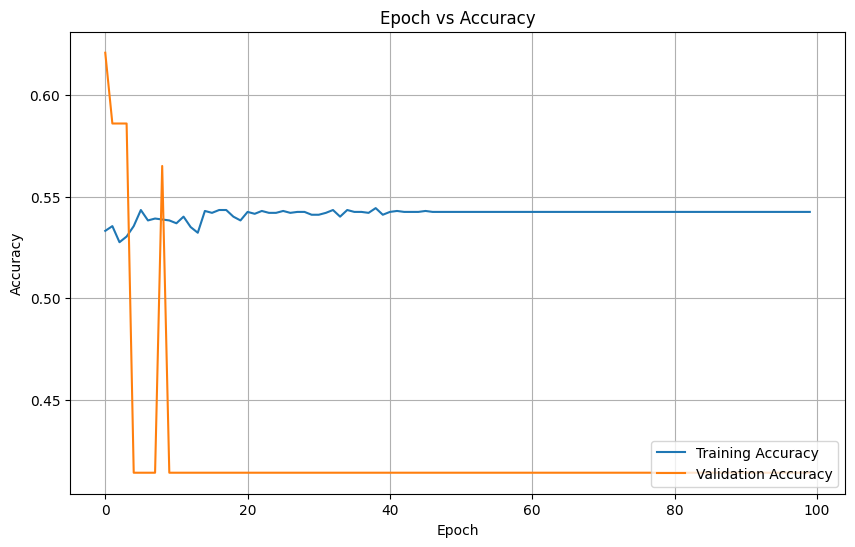

In [9]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/kaggle/working/mobilenetv1_models/accuracy_plot.png')
plt.show()

In [10]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,430,789 (39.79 MB)

 Trainable params: 3,469,633 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 6,939,268 (26.47 MB)

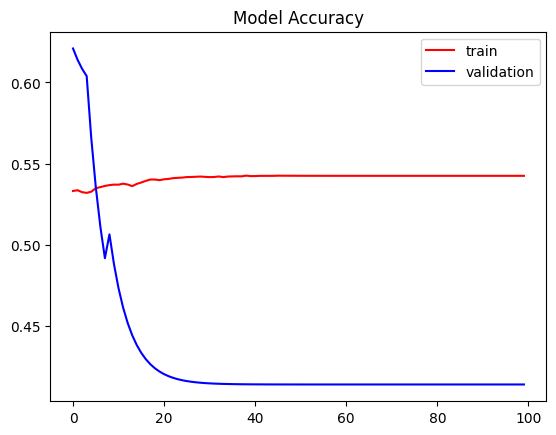

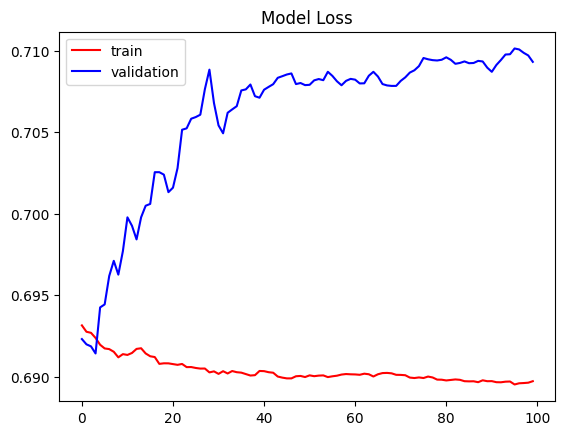

In [11]:
import matplotlib.pyplot as plt
# Plot training curves
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

plt.plot(smooth_curve(history.history['accuracy']), color='red', label='train')
plt.plot(smooth_curve(history.history['val_accuracy']), color='blue', label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(smooth_curve(history.history['loss']), color='red', label='train')
plt.plot(smooth_curve(history.history['val_loss']), color='blue', label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

In [14]:
# Load the Validation Dataset

from tensorflow.keras.utils import image_dataset_from_directory

test_dir = '/kaggle/input/mpoxnew1/monkeypox/Fold1/Fold1/Fold1/Test'

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)
# Evaluate the model on test dataset
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 56 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5461 - loss: 0.6892
Test Loss: 0.6881
Test Accuracy: 0.5536


In [15]:
# Evaluate on test set
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5357 - loss: 0.6908
Test Loss: 0.6881
Test Accuracy: 0.5536


In [16]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score

# Classification report and AUC
y_true = []
y_pred_probs = []

# Resize images to (224, 224) to match InceptionV3 input requirements
def resize_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to (224, 224)
    return image, label

# Apply resizing to the test dataset
test_ds_resized = test_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Predict on resized test dataset
for images, labels in test_ds_resized:
    preds = best_model.predict(images).flatten()  # Predict probabilities
    y_true.extend(labels.numpy())  # True labels
    y_pred_probs.extend(preds)     # Predicted probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Classification report
class_names = test_ds.class_names
print(classification_report(y_true, (y_pred_probs > 0.5).astype(int), target_names=class_names))

# AUC-ROC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC-ROC: {auc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

      Others       0.00      0.00      0.00        25
   monkeypox       0.55      1.00      0.71        31

    accuracy                           0.55        56
   macro avg       0.28      0.50      0.36        56
weighted avg       0.31      0.55      0.39        56

AUC-ROC: 0.3161


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


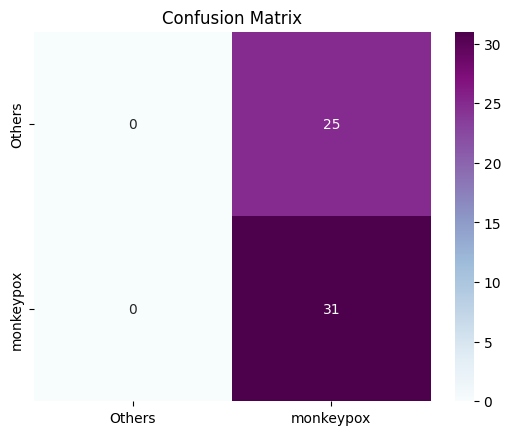

In [17]:
# Confusion matrix
cm = confusion_matrix(y_true, (np.array(y_pred_probs) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names,cmap="BuPu")
plt.title('Confusion Matrix')
plt.show()

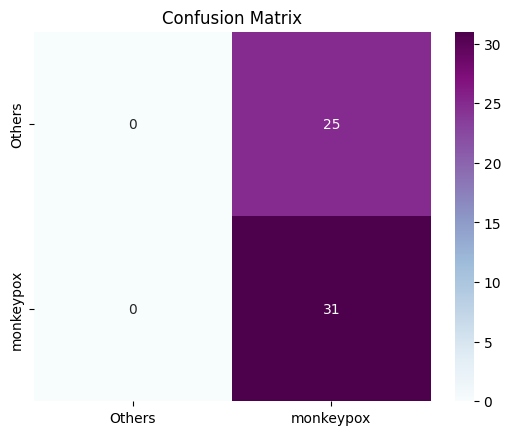

In [19]:
# Confusion matrix
cm = confusion_matrix(y_true, (np.array(y_pred_probs) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names,cmap="BuPu")
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images).flatten()
    pred_labels = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels)
class_name=["monkeypox","others"]
class_names = validation_ds.class_names  # ['monkeypox', 'others']

print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# Load the Validation Dataset

from tensorflow.keras.utils import image_dataset_from_directory

test_dir = '/content/Fold1/Fold1/Fold1/Test'

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)
# Normalize images
def preprocess(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Train class counts:
Others: 1162
Monkeypox: 980
